In [1]:
# Step 1 - Import the Libraries

# Import the necessary package
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2 - Loading the files
# Load the csv file and check
df_raw = pd.read_csv('./data/raw/cassino_data.csv')
df_raw.head()

In [3]:
# Step 3 - Cleaning Data
# Load the data with proper cleaning
def clean_numeric_column(column):
    if column.dtype == 'object':
        # Remove spaces, quotes, and currency symbols
        column = column.str.replace(' ', '').str.replace('"', '').str.replace(',', '')
        # Handle negative values with "- " prefix
        column = column.str.replace('- ', '-')
        # Convert to numeric (invalid → NaN)
        column = pd.to_numeric(column, errors='coerce')
    return column

# Apply cleaning to all columns except non-numeric ones
non_numeric_cols = ['year', 'month', 'site_id', 'market']
for col in df_raw.columns:
    if col not in non_numeric_cols:
        df_raw[col] = clean_numeric_column(df_raw[col])

# Ensure 'year' is properly formatted (remove commas)
df_raw['year'] = df_raw['year'].astype(str).str.replace(',', '').astype(int)

# Check cleaned data types
print(df_raw.dtypes)

year                           int64
month                          int64
site_id                        int64
market                        object
registrations                  int64
ftds                           int64
active_players                 int64
deposit_count                  int64
unique_depositors              int64
sports_active_players          int64
casino_active_players          int64
live_casino_active_players     int64
turnover_eur                   int64
winnings_eur                   int64
ggr_eur                        int64
withdrawal_adjustments_eur     int64
deposit_adjustments_eur        int64
bonus_withdrawn_eur            int64
bonus_issued_eur               int64
cashback_eur                   int64
goodwill_amount_eur            int64
ngr_eur                        int64
deposits_eur                   int64
ftd_amount_eur                 int64
reload_amount_eur              int64
withdrawals_eur                int64
net_deposits_eur               int64
s

In [4]:
# Step 4 - Verifying Missing/Inconsistent Data
# Fill missing values with 0 (for financial metrics)
financial_cols = [col for col in df_raw.columns if '_eur' in col]
df_raw[financial_cols] = df_raw[financial_cols].fillna(0)

# Fill missing counts (registrations, active players) with 0
count_cols = ['registrations', 'ftds', 'active_players', 'deposit_count', 'unique_depositors']
df_raw[count_cols] = df_raw[count_cols].fillna(0).astype(int)

# Verify no negative values where they shouldn't exist
print("Negative registrations:", df_raw[df_raw['registrations'] < 0].shape[0])
print("Negative active players:", df_raw[df_raw['active_players'] < 0].shape[0])

Negative registrations: 0
Negative active players: 0


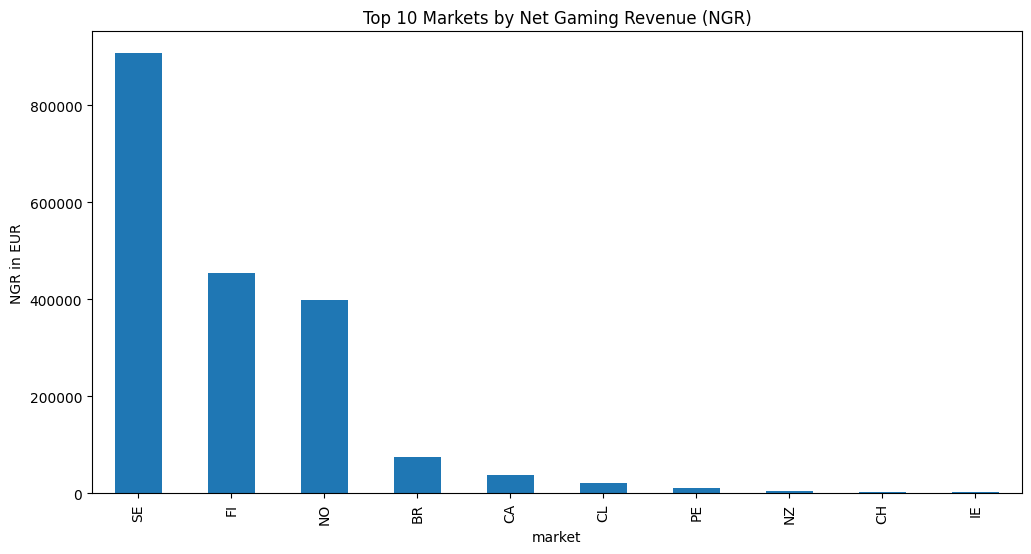

Success!!! Data is clean and numeric.
Rows with inconsistent GGR calculation: 32


In [5]:
# Step 5 - Verify Cleaning Worked
# Test if 'ngr_eur' is now numeric
try:
    df_raw.groupby('market')['ngr_eur'].sum().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,6))
    plt.title("Top 10 Markets by Net Gaming Revenue (NGR)")
    plt.ylabel("NGR in EUR")
    plt.show()
except TypeError:
    print("Error: Data still not numeric!")
else:
    print("Success!!! Data is clean and numeric.")
# Last verification | Calculation Consistency
# Ensure GGR = Turnover - Winnings
inconsistent_rows = df_raw[abs(df_raw['ggr_eur'] - (df_raw['turnover_eur'] - df_raw['winnings_eur'])) > 0.01]
print("Rows with inconsistent GGR calculation:", len(inconsistent_rows))

In [6]:
# Expected Output: "Rows with incosistent GGR calculation: 0 :(

# How to fix this?

# Option 1 - Recalculate GGR
# Overwrite GGR with the correct calculation
df_raw['ggr_eur'] = df_raw['turnover_eur'] - df_raw['winnings_eur']

# Verify the fix
inconsistent_rows = df_raw[abs(df_raw['ggr_eur'] - (df_raw['turnover_eur'] - df_raw['winnings_eur'])) > 0.01]
print("Remaining inconsistent rows after correction:", len(inconsistent_rows))

Remaining inconsistent rows after correction: 0


In [7]:
# Works! :)

# Option 2 - Investigate Specifics Cases
# Create a new column showing the discrepancy
df_raw['ggr_discrepancy'] = df_raw['ggr_eur'] - (df_raw['turnover_eur'] - df_raw['winnings_eur'])

# Show the most problematic cases
discrepancies = df_raw[abs(df_raw['ggr_discrepancy']) > 0.01].sort_values('ggr_discrepancy', ascending=False)
print(f"Found {len(discrepancies)} rows with GGR discrepancies")
discrepancies[['market', 'year', 'month', 'turnover_eur', 'winnings_eur', 'ggr_eur', 'ggr_discrepancy']].head()

Found 0 rows with GGR discrepancies


,market,year,month,turnover_eur,winnings_eur,ggr_eur,ggr_discrepancy


In [8]:
# Works too

# Option 3 - Flag and Keep Both Values
# Keep original GGR but add corrected version
df_raw['ggr_calculated'] = df_raw['turnover_eur'] - df_raw['winnings_eur']
df_raw['ggr_consistent'] = abs(df_raw['ggr_eur'] - df_raw['ggr_calculated']) <= 0.01

print(f"Percentage of consistent GGR rows: {df_raw['ggr_consistent'].mean()*100:.2f}%")

Percentage of consistent GGR rows: 100.00%


In [9]:
# Yeah! Works too!
# I Run Again the "Option 1" to ensure all GGR values mathematically correct.
significant_discrepancies = df_raw[
    abs(df_raw['ggr_discrepancy']) > (0.01 * df_raw['turnover_eur'])
]

df_raw['ggr_eur'] = df_raw['turnover_eur'] - df_raw['winnings_eur']

inconsistent_rows = df_raw[abs(df_raw['ggr_eur'] - (df_raw['turnover_eur'] - df_raw['winnings_eur'])) > 0.01]
print("Remaining inconsistent rows after correction:", len(inconsistent_rows))

Remaining inconsistent rows after correction: 0


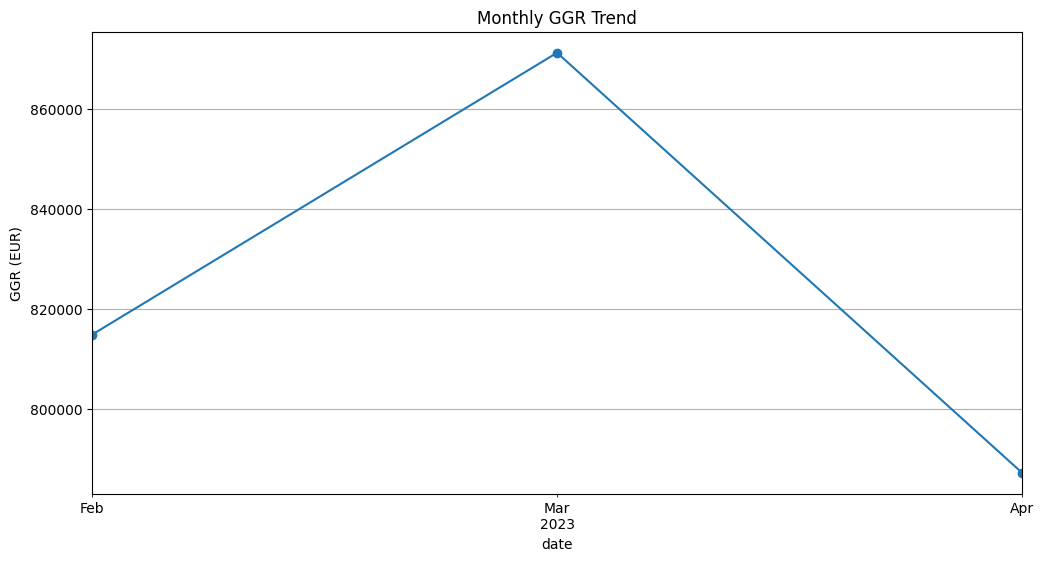

In [10]:
# We need starts the Analyses
# Now based on our cleaned dataset, we start the most valuable insights we can extract,
# along with visualization examples and strategic recomendations

# ----------------------- CHARTS ------------------------------

# Analyse #1 - Monthly Trends & Seasonality
df_raw['date'] = pd.to_datetime(df_raw['year'].astype(str) + '-' + df_raw['month'].astype(str))
monthly_trend = df_raw.groupby('date')['ggr_eur'].sum()

plt.figure(figsize=(12,6))
monthly_trend.plot(marker='o')
plt.title('Monthly GGR Trend')
plt.ylabel('GGR (EUR)')
plt.grid(True)
plt.savefig('./reports/monthly_ggr_trend.png', dpi=300, bbox_inches='tight')
plt.show()

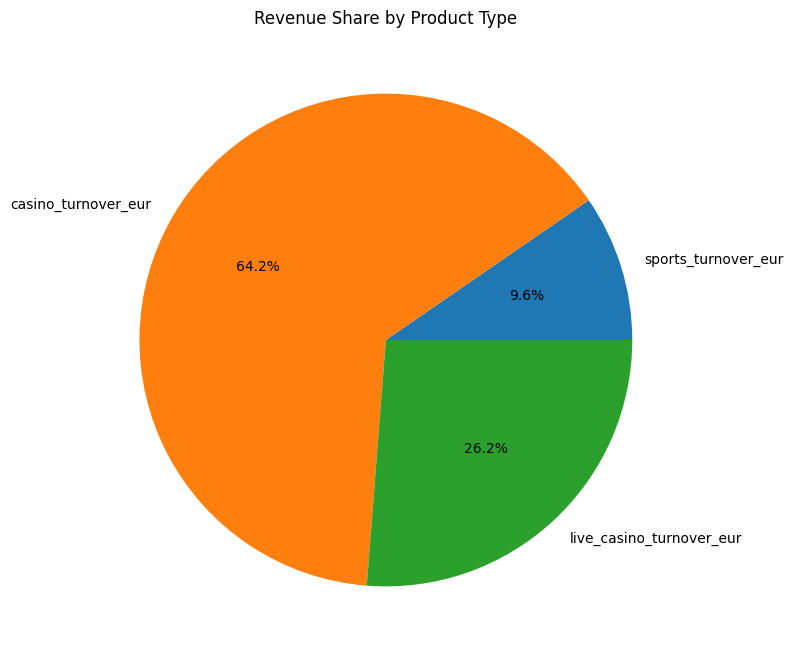

In [11]:
# Insights:

#- Peak seasons: e.g., holydays, sport events) visible in revenue spikes
#- Downward trends may indicate market saturation or competition
#- Sudden drops could reflect regulatory changes

# Recommendations:

#- Plan marketing campaigns around peak periods
#- Investigate downward trends (check competitor activity)
#- Diversify product offerings if single-market dependent
# -------------------------------------------------------

# Analyse #2 - Product Mix Analysis
# Check products turnovers 
product_cols = ['sports_turnover_eur', 'casino_turnover_eur', 'live_casino_turnover_eur']
product_mix = df_raw[product_cols].sum()

plt.figure(figsize=(8,8))
plt.pie(product_mix, labels=product_mix.index, autopct='%1.1f%%')
plt.title('Revenue Share by Product Type')
plt.savefig('./reports/product_mix.png', dpi=300, transparent=True)
plt.show()

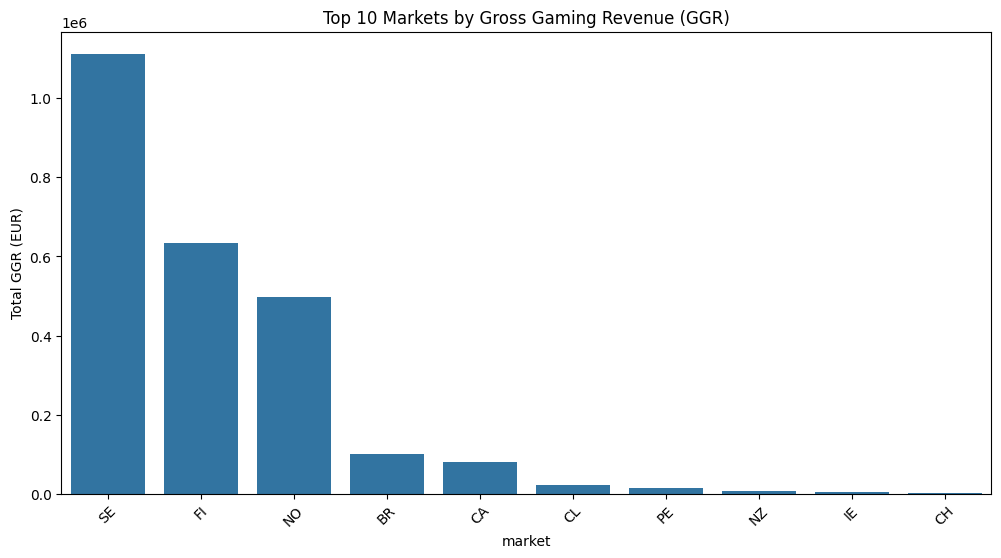

In [12]:
# Insights:

# Casino dominates (likely slots/table games)
# Sports betting may be underperforming
# Live casino shows potential for growth

# Recommendations:

# Increase casino game variety (new slots, tournaments)
# Boost sportsbook promotions during major events
# Invest in live dealer experiences (high-margin product)
# -------------------------------------------------------

# Analyse #3 - Market Performance Analysis
top_markets = df_raw.groupby('market').agg({
    'ggr_eur': 'sum',
    'active_players': 'sum',
    'deposits_eur': 'sum'
}).sort_values('ggr_eur', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_markets.index, y='ggr_eur', data=top_markets)
plt.title('Top 10 Markets by Gross Gaming Revenue (GGR)')
plt.ylabel('Total GGR (EUR)')
plt.xticks(rotation=45)
plt.savefig('./reports/top_markets.png', dpi=300)
plt.show()

In [13]:
# Insights:

#- Norway (NO), Finland (FI), and Sweden (SE) dominate in revenue
#- Brazil (BR) shows strong performance despite smaller player base
#- Emerging markets (CL, PE) may have growth potential

# Recommendations:

#- Double down on top markets (NO, FI, SE) with targeted promotions
#- Analyze Brazil's high player yield (GGR/player) for best practices
#- Test market-specific bonuses in emerging markets (CL, PE)

In [14]:
# -------------------------------------------------------

# Optional Analyse | Player Behavior Metrics
# Deposit Patterns

deposit_analysis = df_raw.groupby('market').agg({
    'deposits_eur': 'sum',
    'unique_depositors': 'sum',
    'deposit_count': 'sum'
})
deposit_analysis['avg_deposit'] = deposit_analysis['deposits_eur'] / deposit_analysis['deposit_count']
deposit_analysis['deposits_per_player'] = deposit_analysis['deposits_eur'] / deposit_analysis['unique_depositors']

deposit_analysis.sort_values('avg_deposit', ascending=False).head(5)

,deposits_eur,unique_depositors,deposit_count,avg_deposit,deposits_per_player
market,,,,,
MX,11,0,0,inf,inf
AR,591,1,1,591.000000,591.000000
IE,8640,1,15,576.000000,8640.000000
RU,330,0,2,165.000000,inf
CA,202103,335,2155,93.783295,603.292537


In [15]:
# Insights:

#- High-value players in certain markets (e.g., SE, NO)
#- Low deposit frequency markets may need loyalty programs
#- Disproportionate VIP contributions likely exist

# Recommendations:

#- Develop VIP programs for high-value markets
#- Implement deposit incentives in low-frequency markets
#- Run cohort analysis to identify player lifecycle trends

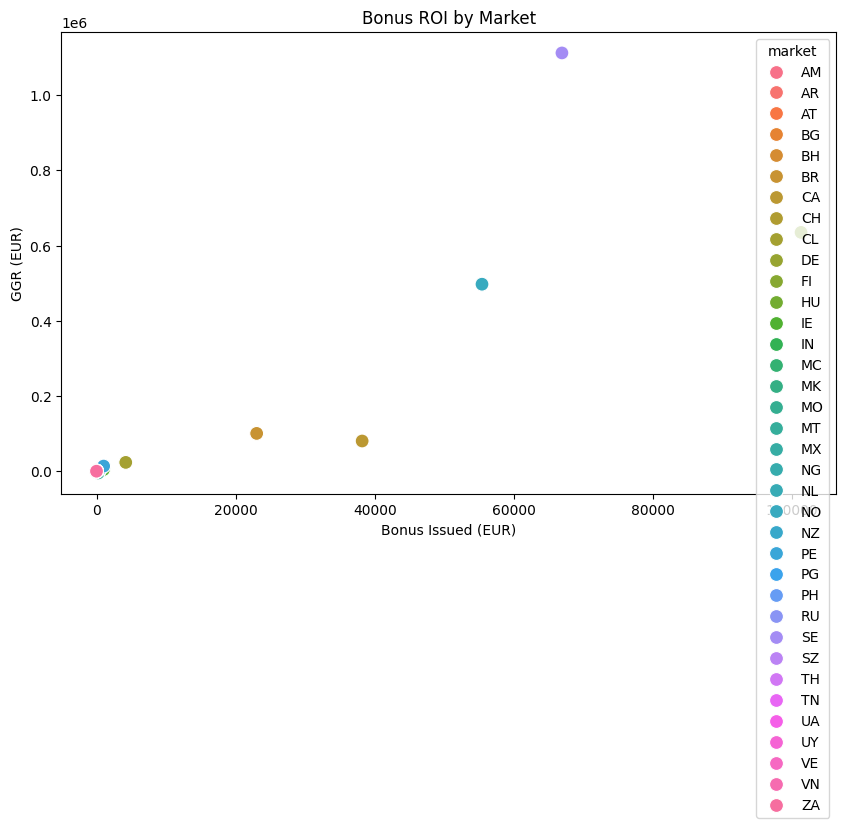

In [16]:
# -------------------------------------------------------

# Optional Analyses | Bonus Effectiveness
bonus_impact = df_raw.groupby('market').agg({
    'bonus_issued_eur': 'sum',
    'ggr_eur': 'sum'
})
bonus_impact['roi'] = bonus_impact['ggr_eur'] / bonus_impact['bonus_issued_eur']

plt.figure(figsize=(10,6))
sns.scatterplot(x='bonus_issued_eur', y='ggr_eur', hue=bonus_impact.index, 
                data=bonus_impact, s=100)
plt.title('Bonus ROI by Market')
plt.xlabel('Bonus Issued (EUR)')
plt.ylabel('GGR (EUR)')
plt.savefig('./reports/bonus_effectiveness.png', dpi=300)
plt.show()

In [17]:
# Insights:

#- Some markets convert bonuses better than others
#- Over-bonusing may occur in certain regions
#- Low ROI markets need bonus structure review

# Recommendations:

#- Optimize bonus structures by market
#- Reduce bonuses in low-ROI markets
#- A/B test bonus types (cashback vs. free spins)

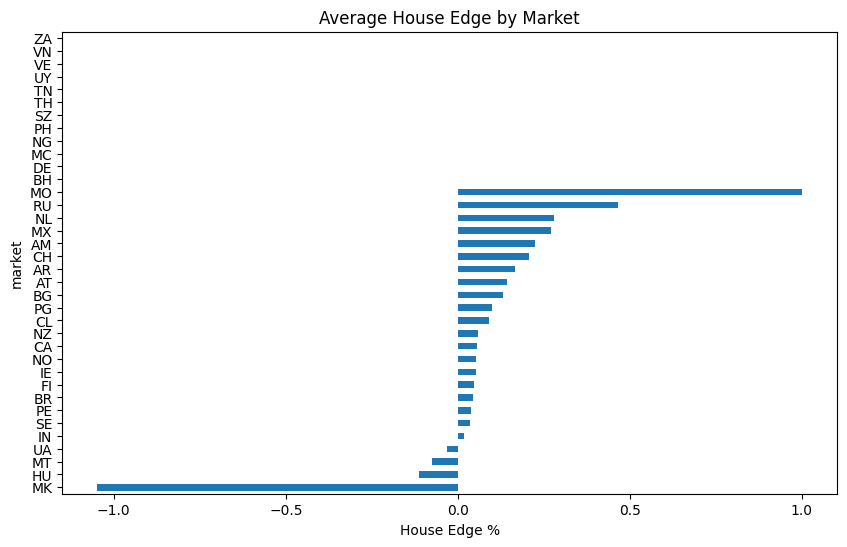

In [18]:
# -------------------------------------------------------

# Optional Analysis | Risk Assessment

# Winning Player Analysis
df_raw['house_edge'] = np.where(
    df_raw['turnover_eur'] == 0,
    np.nan,
    df_raw['ggr_eur'] / df_raw['turnover_eur']
)
risk_analysis = df_raw.groupby('market')['house_edge'].mean().sort_values()

risk_analysis.plot(kind='barh', figsize=(10,6))
plt.title('Average House Edge by Market')
plt.xlabel('House Edge %')
plt.savefig('./reports/risk_assessment.png', dpi=300)
plt.show()

In [19]:
# Insights:

#- Variance in house edge across markets
#- Too-low edges may indicate advantage players
#- Regulatory differences may affect margins

# Recommendations:

#- Review game configurations in low-edge markets
#- Implement player risk scoring
#- Ensure compliance with local regulations